In [1]:
from datasets import load_dataset
from datasets import Dataset
from pathlib import Path

/home/dragos/miniforge3/envs/deep-learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load our data in a dataset object

In [2]:
article_path = Path("data/newsela_article_corpus_2016-01-29/articles")
columns = ["slug", "language", "title", "grade_level", "version", "filename"]
raw_dataset = Dataset.from_csv("data/newsela_article_corpus_2016-01-29/articles_metadata.csv", delimiter=",")

raw_dataset = raw_dataset.rename_column("slug", "id")  # Assuming 'slug' is equivalent to 'id'

def load_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

# Create a function to process and prepare the dataset
def process_dataset(example):
    # Customize this function based on your needs
    return {
        "en": load_file(Path(article_path, example["filename"])), 
        "s_en": load_file(Path(article_path,(example["filename"][:-5]
                                                 +str(1)
                                                 +".txt"))),
        "id": example["filename"]
    }

raw_dataset = raw_dataset.filter(lambda x: int(x["version"]) == 0)
raw_dataset = raw_dataset.filter(lambda x: x["filename"] != "US-Constitution.en.0.txt")
raw_dataset = raw_dataset.filter(lambda x: x['language'] == 'en')

# Apply the processing function to the dataset
processed_dataset = raw_dataset.map(process_dataset)


processed_dataset.set_format(type="torch",
                             columns=["en", "id", "s_en"])

# Print the processed dataset
print(processed_dataset)

Dataset({
    features: ['id', 'language', 'title', 'grade_level', 'version', 'filename', 'en', 's_en'],
    num_rows: 1910
})


#### Check how some datasets look compared to ours

In [3]:
processed_dataset[0]

{'id': '10dollarbill-woman.en.0.txt',
 'en': 'WASHINGTON — An abolitionist. The longest-serving first lady. The Labor secretary through the Great Depression. The founder of the Girl Scouts.\n\nThese are some of the candidates to be the first woman on U.S. currency notes in more than a century. Treasury Secretary Jacob J. Lew announced the plans this week, saying the all-male lineup on American money has gone on long enough.\n\n"We will right that wrong, and when the new, redesigned $10 note is released, it will bear the portrait of a woman," he said at the National Archives in Washington.\n\nWhile Lew gets to decide who is featured, he and other Treasury officials will fan out across the country to solicit suggestions. They\'ve set up a website and enlisted Twitter to spread the word. A non-profit group called Women On 20s, formed to convince President Barack Obama to put a woman\'s image on the $20 note, already has done some polling.\n\nThe winner in that contest was Harriet Tubman, 

In [4]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [5]:
books = load_dataset("opus_books", "en-fr")
books['train'][0]

{'id': '0', 'translation': {'en': 'The Wanderer', 'fr': 'Le grand Meaulnes'}}

In [6]:
alpaca = load_dataset("tatsu-lab/alpaca")
alpaca["train"][5]

{'instruction': 'Identify the odd one out.',
 'input': 'Twitter, Instagram, Telegram',
 'output': 'Telegram',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the odd one out.\n\n### Input:\nTwitter, Instagram, Telegram\n\n### Response:\nTelegram'}

### Transform our data to be similar to alpaca data 

In [7]:
article_path = Path("data/newsela_article_corpus_2016-01-29/articles")
columns = ["slug", "language", "title", "grade_level", "version", "filename"]
raw_dataset = Dataset.from_csv("data/newsela_article_corpus_2016-01-29/articles_metadata.csv", delimiter=",")

raw_dataset = raw_dataset.rename_column("slug", "id")  # Assuming 'slug' is equivalent to 'id'

def load_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()
    
def format_instruction(en: str, s_en: str, model_type: str="llama"):
    if model_type == "llama":
        # return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
        #     ### Instruction:
        #     Simplify the text.

        #     ### Input:
        #     {en.strip()}

        #     ### Summary:
        #     {s_en}
        #     """.strip()
        return f"""<s>[INST] <<SYS>>
        Below is an instruction that describes a task. Write a response that appropriately completes the request.
        <</SYS>>
        
        Simplify the text:
        {en.strip()}
        [/INST]
        
        The simplified text is:
        {s_en.strip()} </s>
        """.strip()
    elif model_type == "mistral":
        return f"""<s>[INST] Simplify the following text:\n{en.strip()} [/INST] \n A simplified version of the text is the following:\n {s_en}""".strip()

# Create a function to process and prepare the dataset
def process_dataset(example):
    # apply preprocessing and tokenization here ??
    en = load_file(Path(article_path, example["filename"]))
    s_en = load_file(Path(article_path,(example["filename"][:-5]
                                                 +str(1)
                                                 +".txt")))
    return {
        "instruction": "Simplify the text",
        "input": en, 
        "output": s_en,
        "id": example["filename"],
        "text": format_instruction(en, s_en, "llama")
    }

raw_dataset = raw_dataset.filter(lambda x: int(x["version"]) == 0)
raw_dataset = raw_dataset.filter(lambda x: x["filename"] != "US-Constitution.en.0.txt")
raw_dataset = raw_dataset.filter(lambda x: x['language'] == 'en')

# Apply the processing function to the dataset
alpaca_like_dataset = raw_dataset.map(process_dataset)


alpaca_like_dataset.set_format(type="torch",
                             columns=["instruction", "input", "output", "id", "text"])

# Print the processed dataset
print(alpaca_like_dataset)

Map:   0%|          | 0/1910 [00:00<?, ? examples/s]

Map: 100%|██████████| 1910/1910 [00:00<00:00, 5983.73 examples/s]

Dataset({
    features: ['id', 'language', 'title', 'grade_level', 'version', 'filename', 'instruction', 'input', 'output', 'text'],
    num_rows: 1910
})


In [8]:
alpaca_like_dataset[0]

{'id': '10dollarbill-woman.en.0.txt',
 'instruction': 'Simplify the text',
 'input': 'WASHINGTON — An abolitionist. The longest-serving first lady. The Labor secretary through the Great Depression. The founder of the Girl Scouts.\n\nThese are some of the candidates to be the first woman on U.S. currency notes in more than a century. Treasury Secretary Jacob J. Lew announced the plans this week, saying the all-male lineup on American money has gone on long enough.\n\n"We will right that wrong, and when the new, redesigned $10 note is released, it will bear the portrait of a woman," he said at the National Archives in Washington.\n\nWhile Lew gets to decide who is featured, he and other Treasury officials will fan out across the country to solicit suggestions. They\'ve set up a website and enlisted Twitter to spread the word. A non-profit group called Women On 20s, formed to convince President Barack Obama to put a woman\'s image on the $20 note, already has done some polling.\n\nThe win

 'text': '<s>[INST] <<SYS>>\n        Below is an instruction that describes a task. Write a response that appropriately completes the request.\n        <</SYS>>\n        \n        Simplify the text:\n        WASHINGTON — An abolitionist. The longest-serving first lady. The Labor secretary through the Great Depression. The founder of the Girl Scouts.\n\nThese are some of the candidates to be the first woman on U.S. currency notes in more than a century. Treasury Secretary Jacob J. Lew announced the plans this week, saying the all-male lineup on American money has gone on long enough.\n\n"We will right that wrong, and when the new, redesigned $10 note is released, it will bear the portrait of a woman," he said at the National Archives in Washington.\n\nWhile Lew gets to decide who is featured, he and other Treasury officials will fan out across the country to solicit suggestions. They\'ve set up a website and enlisted Twitter to spread the word. A non-profit group called Women On 20s, formed to convince President Barack Obama to put a woman\'s image on the $20 note, already has done some polling.\n\nThe winner in that contest was Harriet Tubman, the escaped black slave who became one of the country\'s leading abolitionists in the years before the Civil War, helping hundreds to freedom. She got 118,328 of a total of 352,431 votes in the final round.\n\nShe is also a symbol of the U.S. economy\'s transformation, according to Justin Wolfers, a senior fellow at the Peterson Institute for International Economics in Washington.\n\n"The key drivers of the economic growth over the past century or so have been both the emancipation of the African-Americans and the integration of women into regular economic life," Wolfers said in an interview. "Selecting Harriet Tubman obviously speaks to both of those movements."\n\nThe Treasury is collecting feedback on the website thenew10.treasury.gov and with the Twitter hashtag "#TheNew10." It will also host open houses, starting June 24 at the Bureau of Engraving and Printing in Fort Worth, Texas.\n\nLew will attend some of those public meetings. He said he has "a bunch of candidates" but will withhold his judgment until he hears from the American people. He plans to make a decision later this year. The only requirements are that the person be deceased and fit the theme of democracy.\n\nEleanor Roosevelt, first lady from 1933 to 1945 and an activist for women, human rights and civil rights, was second in the Women On 20s poll. She is favored by the Association of Junior Leagues International Inc., an organization she belonged to in its early days.\n\n"She was really instrumental in founding the movement for future generations of civic leaders and was there right when it started," said Laurie Dodge, director of marketing and development at the association.\n\nThe Girl Scouts endorsed Juliette Gordon Low, who founded the organization in 1912 in Savannah, Georgia.\n\n"She was a champion for democracy and a force for good," the organization, now based in New York and with more than 2.8 million members in the United States, said on Twitter recently.\n\nThe Treasury expects to unveil the new $10 bill in 2020, the 100th anniversary of the passage of the 19th Amendment, which gave women the right to vote. The department can\'t specify when the new notes will start circulating, because selection and design of the image will be followed by an exhaustive production process. The redesign of the $100 note issued in October 2013 took about 14 years.\n\nBarbara Ortiz Howard, the founder of Women On 20s, said her organization is fine with a woman on $10 rather than $20 notes. Either way, the goal of seeing a female on paper money by the voting rights centennial is achieved, Howard said.\n\nMore than 600,000 people voted on Women on 20s list of 15 candidates during a 10-week period. On May 12, the organization presented Obama with the results.\n\nAnother candidate could be Frances Perkins, Labor secretary from 1933 to 1945 and the first woman appointed to the Cabinet, Wolfers said. House Minority Leader Nancy Pelosi, a Democrat from California, is backing Perkins.\n\n"Frances Perkins was the Labor secretary at a time when the Department of Labor was incredibly active," Wolfers said. "She helped establish unemployment benefits, the minimum wage, the adoption of the 40-hour work week, and a range of worker protections that make up our modern safety net."\n\nFormer Rhode Island Governor Lincoln Chafee, who is running for the Democratic presidential nomination, is backing Rachel Carson, whose 1962 book Silent Spring is widely credited with launching the modern environmental movement.\n\nThe $10 bill was chosen for the new image because it was designated by a special committee on security and counterfeit deterrence in June 2013 as the next currency note to be redesigned. The committee, which includes representatives from the Treasury, the Federal Reserve Board, the Secret Service and the Bureau of Engraving and Printing, focuses on security features that can be used to deter counterfeiting.\n\nLew said that $10 note will be the first in the new series of redesigned notes, all including images capturing the theme of democracy.\n\nThe last changes of portraits on U.S. currency were between 1914 and 1928, when four adjustments were made: Alexander Hamilton, the first Treasury secretary, replaced Andrew Jackson on the $10 bill; Jackson\'s image moved to the $20 bill, replacing Grover Cleveland, who now graces the $1,000 bill; and William McKinley replaced John Marshall on the $500 bill.\n\nLew has said that Hamilton\'s image will remain part of the new $10 bill. The last woman to appear on U.S. paper currency was Martha Washington in the late 19th century.\n        [/INST]\n        \n        The simplified text is:\n        WASHINGTON — The all-male lineup on American money has gone on long enough, Treasury Secretary Jacob J. Lew said.\n\n"We will right that wrong, and when the new, redesigned $10 note is released, it will bear the portrait of a woman," he said in Washington, D.C., recently.\n\nWho are some of the candidates to be the first woman on U.S. currency notes in more than a century? A former slave who worked to abolish slavery. The longest-serving first lady. The Labor secretary through the Great Depression. The founder of the Girl Scouts.\n\n## Harriet Tubman A Popular Contender\n\nWhile Lew gets to decide who is featured, he and other Treasury officials will go across the country to ask for suggestions. They have set up a website and enlisted Twitter to spread the word. A non-profit group called Women On 20s, formed to convince President Barack Obama to put a woman\'s image on the $20 note, already has done some opinion polling.\n\nThe winner in that contest was Harriet Tubman, the escaped black slave who became one of the country\'s leading abolitionists before the Civil War, helping hundreds to freedom. She got 118,328 of a total of 352,431 votes in the final round.\n\nTubman is also a symbol of the U.S. economy\'s transformation, according to Justin Wolfers. He is with the Peterson Institute for International Economics in Washington. He said when women and African-Americans were allowed to work it gave a boost to the economy, as more people were working, building things and spending money.\n\n"The key drivers of the economic growth over the past century or so have been both the emancipation of the African-Americans and the integration of women into regular economic life," Wolfers said. "Selecting Harriet Tubman obviously speaks to both of those movements."\n\n## There\'s Even "#TheNew10"\n\nThe Treasury Department is collecting feedback on the website thenew10.treasury.gov and with the Twitter hashtag "#TheNew10." It will also host open houses, starting June 24, at the Bureau of Engraving and Printing in Fort Worth, Texas.\n\nLew will attend some of those public meetings. He said he has "a bunch of candidates" but will wait until he hears from the American people. He plans to make a decision later this year. The only requirements are that the woman is no longer alive and fits the theme of democracy.\n\nEleanor Roosevelt was the first lady from 1933 to 1945 and an activist for women, human rights and civil rights. She came in second in the Women On 20s poll.\n\nThe Girl Scouts endorsed Juliette Gordon Low, who founded the organization in 1912.\n\n"She was a champion for democracy and a force for good," said the organization on Twitter. The Girl Scouts now has more than 2.8 million members in the United States.\n\n## Printing New Money Will Take Time\n\nThe Treasury Department expects to unveil the new $10 bill in 2020, the 100th anniversary of the passage of the 19th Amendment, which gave women the right to vote. The department cannot specify when the new notes will be in use. After the woman is selected, the bill must be designed and then printed. The redesign of the $100 note issued in October 2013 took about 14 years.\n\nBarbara Ortiz Howard, the founder of Women On 20s, said her organization is fine with a woman on $10 rather than $20 notes. Either way, it achieves her goal of seeing a female on paper money by the 100th anniversary of the voting rights amendment, Howard said.\n\nMore than 600,000 people voted on Women on 20s\' list of 15 candidates during a 10-week period. On May 12, the organization presented Obama with the results.\n\n## Other Potential Candidates\n\nAnother candidate could be Frances Perkins, federal Labor secretary from 1933 to 1945 and the first woman appointed to the presidential Cabinet, Wolfers said. House Minority Leader Nancy Pelosi, a Democrat from California, is backing Perkins.\n\n"Frances Perkins was the labor secretary at a time when the Department of Labor was incredibly active," Wolfers said. "She helped establish unemployment benefits, the minimum wage, the adoption of the 40-hour work week, and a range of worker protections that make up our modern safety net."\n\nFormer Rhode Island Governor Lincoln Chafee, who is running for the Democratic presidential nomination, is backing Rachel Carson. Her 1962 book "Silent Spring" is widely credited with launching the modern environmental movement.\n\n## More Currency Facelifts To Come\n\nThe $10 bill was chosen for the new image because it was designated by a special committee that fights illegal printing of money – or counterfeiting — as the next currency note to be redesigned. The committee, which includes representatives from the Treasury, the Federal Reserve Board, the Secret Service and the Bureau of Engraving and Printing, focuses on security features that can be used to discourage counterfeiting.\n\nLew said that $10 note will be the first in the new series of redesigned notes, all including images on the theme of democracy.\n\nThe last changes of portraits on U.S. currency were between 1914 and 1928, when four adjustments were made. Alexander Hamilton, the first Treasury secretary, replaced President Andrew Jackson on the $10 bill. Jackson\'s image moved to the $20 bill, replacing President Grover Cleveland, who was put on the $1,000 bill. President William McKinley replaced John Marshall on the $500 bill.\n\nLew has said that Hamilton\'s image will remain part of the new $10 bill. The last woman to appear on U.S. paper currency was Martha Washington in the late 19th century. </s>'


In [9]:
import dill as pickle

with open('data/dataset.pkl', 'wb') as f:
    pickle.dump(alpaca_like_dataset, f)

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoConfig, PretrainedConfig, BitsAndBytesConfig
from unsloth import FastLanguageModel
import torch


model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "mesolitica/llama-1b-hf-32768-fpf"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

kwargs = {'attn_implementation': 'flash_attention_2'}
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name, # Supports Llama, Mistral - replace this!
    max_seq_length = 4096,
    dtype = None,
    load_in_4bit = True,
    **kwargs
)

==((====))==  Unsloth: Fast Mistral patching release 2024.1
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.659 GB
O^O/ \_/ \    CUDA capability = 8.6. Xformers = 0.0.23.post1. FA = True.
\        /    Pytorch version: 2.1.2. CUDA Toolkit = 12.1
 "-____-"     bfloat16 = TRUE. Platform = Linux

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


In [11]:
lengths = []
for sample in alpaca_like_dataset:
    ids = tokenizer(sample['text'])['input_ids']
    lengths.append(len(ids))

Token indices sequence length is longer than the specified maximum sequence length for this model (4212 > 4096). Running this sequence through the model will result in indexing errors


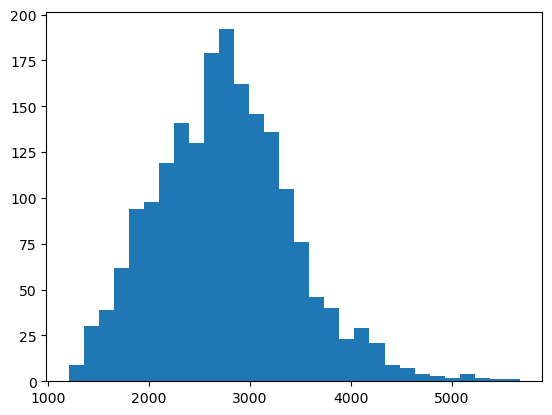

In [12]:
from matplotlib import pyplot as plt
bins, values, _ = plt.hist(lengths, bins=30)

In [13]:
thr = 4096
print(f'There are {sum([b for idx, b in enumerate(bins) if values[idx] > thr])} samples that will be cut off early if we use a context length of {thr}, amounting for a percentage of {sum([b for idx, b in enumerate(bins) if values[idx] > thr])/sum(bins) * 100:.2f}%.')

There are 54.0 samples that will be cut off early if we use a context length of 4096, amounting for a percentage of 2.83%.
